In [1]:
# import matplotlib as plt
import tensorflow as tf
import sklearn
# import nibabel as nib

Model: "model_1"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input_2 (InputLayer)                   [(None, 42, 50, 42, 1)]    0                                                     
________________________________________________________________________________________________________________________
sequential_19 (Sequential)             (None, 20, 24, 20, 15)     6570          input_2[0][0]                           
________________________________________________________________________________________________________________________
sequential_22 (Sequential)             (None, 20, 24, 20, 15)     12240         sequential_19[0][0]                     
________________________________________________________________________________________________________________________
concatenate_3 (

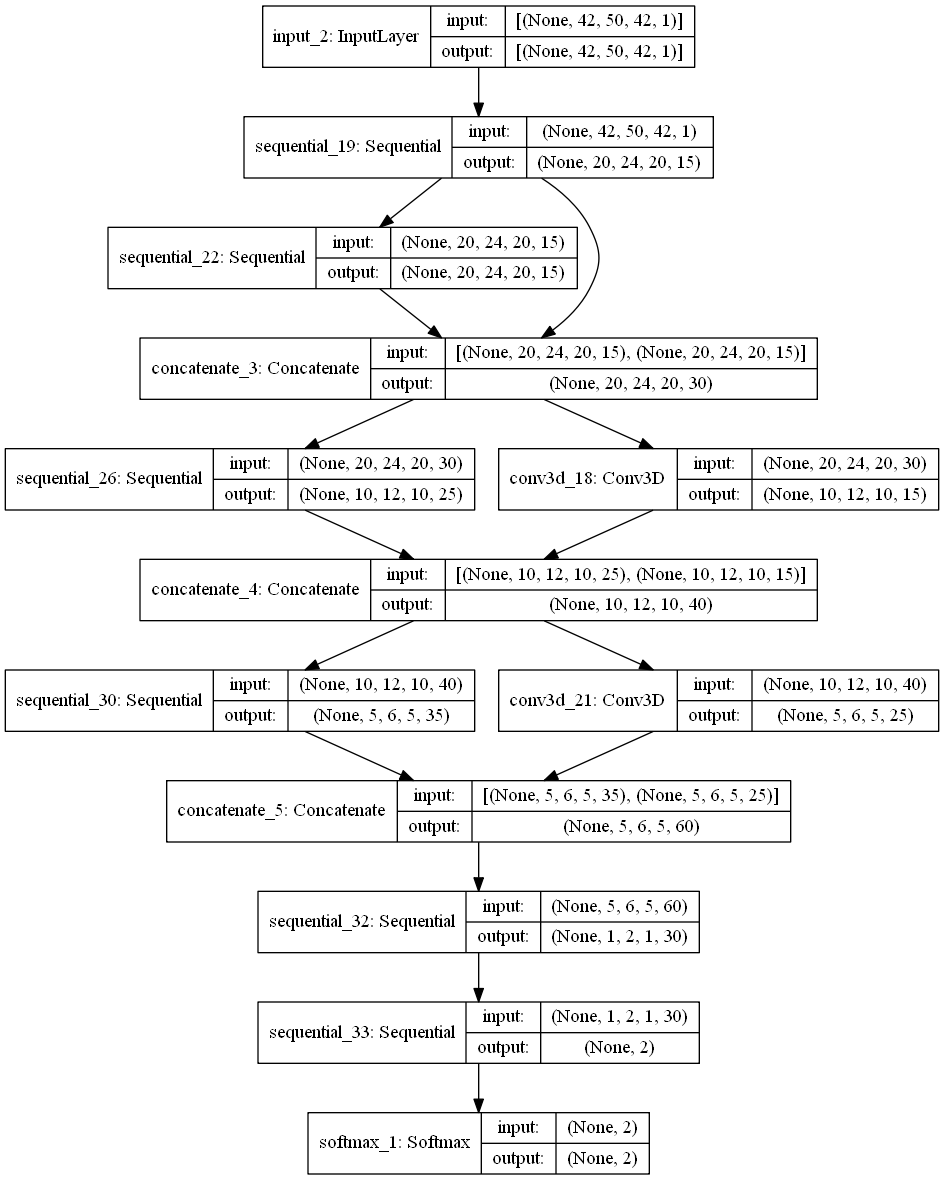

In [4]:
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras import Input,Model,Sequential
from tensorflow.keras import layers,optimizers,losses,metrics
# model=keras.Sequential()
# model.add(layers.InputLayer(input_shape=(50,42,42,1)))
def getmodel():

    #conv3d
    def Conv3D_U(channel):
        return layers.Conv3D(channel,3,padding='same')

    #BN+activate(relu)
    def BN_AC():
        return Sequential([
            layers.BatchNormalization(),
            layers.Activation("relu"),
        ])

    #conv3d+BatchNormalization
    def Conv3D_BN(channel,dp_rate=0):
        return Sequential([
            Conv3D_U(channel),
            BN_AC(),
            layers.Dropout(dp_rate),
        ])

    #Conv3D_Pooling1
    def Conv3D_P1(channel):
        return layers.Conv3D(channel,3,strides=(2,2,2))
    #Conv3D_Pooling2
    def Conv3D_P2(channel):
        return layers.Conv3D(channel,3,strides=(2,2,2),padding='same')
    #Conv3D_Pooling+BatchNormalization
    # why dropout before BatchNormalization?
    def Conv3D_PBN(channel,dp_rate=0):
        return Sequential([
            Conv3D_P2(channel),
            layers.Dropout(dp_rate),
            BN_AC()
        ])

    def Merge():
        return layers.Concatenate()
    def Liner(units,activation=None):
        return layers.Dense(units,activation=activation)
### network blocks
    L0=Sequential([
        Conv3D_BN(15),
        Conv3D_P1(15)
    ])

    L1=Sequential([
        Conv3D_BN(15,0.2),
        Conv3D_U(15)
    ])
    M1=Merge()

    L2=Sequential([
        BN_AC(),
        Conv3D_PBN(25,0.2),
        Conv3D_U(25)
    ])
    R2=Conv3D_P2(15)
    M2=Merge()

    L3=Sequential([
        BN_AC(),
        Conv3D_PBN(35,0.2),
        Conv3D_U(35)
    ])
    R3=Conv3D_P2(25)
    M3=Merge()
    
    L4=Sequential([
        BN_AC(),
        layers.Conv3D(30,3,padding='valid'),
        layers.Conv3D(30,3,padding='valid')
    ])

    FC=Sequential([
        layers.Flatten(),
        Liner(300,'relu'),
        layers.Dropout(0.2),
        Liner(50,'relu'),
        Liner(2)
    ])
    CLF=layers.Softmax()

### network constructure
    inputs = Input(shape=(42,50,42,1), dtype='float32')

    with tf.name_scope('Block0'):
        l0_out=L0(inputs)
    with tf.name_scope('Block1'):
        l1_x=L1(l0_out)
        l1_y=l0_out
        l1_out=M1([l1_x,l1_y])
    with tf.name_scope('Block2'):
        l2_x=L2(l1_out)
        l2_y=R2(l1_out)
        l2_out=M2([l2_x,l2_y])
    with tf.name_scope('Block3'):
        l3_x=L3(l2_out)
        l3_y=R3(l2_out)
        l3_out=M3([l3_x,l3_y])
    with tf.name_scope('Block4'):
        l4_x=L4(l3_out)
    with tf.name_scope('FC'):
        lfc=FC(l4_x)

    outputs=CLF(lfc)

    opt=optimizers.Adadelta()
    loss_func=losses.SparseCategoricalCrossentropy()
    metric=[metrics.SparseCategoricalAccuracy()]

    model=Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=opt,loss=loss_func,metrics=metric)
    return model
# keras.layers.Concatenate()
model=getmodel()
model.summary(line_length=120)
utils.plot_model(model, "myCNN3D.png", show_shapes=True)


In [5]:
from matplotlib import pylab as plt
import nibabel as nib
from nibabel.viewers import OrthoSlicer3D
example_filename = "./datasets/A4/A4_aligned/B10018169/Florbetapir/cmeanA4_B10018169_MR_Florbetapir_Br_20200720182306561_S893044_I1321166.nii.gz"
 
img = nib.load(example_filename)
# OrthoSlicer3D(img.dataobj).show()
fdata=img.get_fdata()
fdata.shape
fdata.mean()

1188.4431195710995

In [7]:
import pandas as pd
import nibabel as nib
import os
df=pd.read_csv("datasets/A4/document/A4_PETVADATA_PRV2.csv")
unusable=[]
x,y=[],[]
maxnum=30
for i,(bid,score) in enumerate(zip(df.BID,df.SCORE)):
    if i==maxnum:break
    try:
        dirname="datasets/A4/A4_aligned/{}/Florbetapir/".format(bid)
        filelist=os.listdir(dirname)
        filename=None
        # print(filelist)
        # input()
        for t_fname in filelist:
            if not '(' in t_fname: filename=t_fname
        # filename=filelist[0]
        if filename is None:
            raise "BID_{}:file not found!".format(bid)
        ngz=nib.load(os.path.join(dirname,filename))
        x.append(ngz.get_fdata())
        y.append(score)
    except Exception as e:
        unusable.append(bid)
        print(e)
        # print("BID_{} unusable.".format(id))
dataset=(x,y)

In [8]:
### data augmentation & preprocessing
from tensorflow.keras import Sequential,layers
#augmentation (don't do like this!)
data_augmentation=Sequential([
    # layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.05),
])
#preprocess(wrong code)
data_preprocess=Sequential([
    layers.BatchNormalization(),# not bn in training
    # layers.experimental.preprocessing.Resizing()
])

AttributeError: module 'tensorflow.keras.layers' has no attribute 'RandomRotation'

In [53]:
from tensorflow import keras
from sklearn.model_selection import train_test_split,KFold
x_train,x_test,y_train,y_test=train_test_split(
    dataset[0],dataset[1],test_size=0.1,random_state=1919810
)
kf = KFold(n_splits=10)

In [49]:
import scipy
import numpy as np
# data_preprocess(x_train,y_train)
def ndresize(x):
    orisize=np.array(x.shape)
    tgsize=np.array((42,50,42))
    return scipy.ndimage.zoom(x,tgsize/orisize,order=1)
def normalize(x):
    return (x-x.mean())/x.std()
def random_padcut3d(x,rate):
    # dim=len(x.shape)
    pc=(x.shape*np.random.uniform(-rate/2.,rate/2.,size=(3))).astype(np.int32)
    pad=np.maximum(0,pc)
    # pad=np.max(np.array((0),dtype=np.int32),pc)
    cut=np.minimum(0,pc)
    cut=tuple([slice(None,None) if c==0 else slice(-c,c) for c in cut])
    
    x=np.pad(x,((pad[0],pad[0]),(pad[1],pad[1]),(pad[2],pad[2])))
    x=x[cut]
    # len(x.shape)
    # dtlist=[np.pad]
    return x
def train_preprocess(x,y,agrate=5):
    x=np.array(x)
    x=normalize(x)
    xlist=[]
    for i in range(agrate):
        x=random_padcut3d(x,0.1)
        x=ndresize(x)
        xlist.append(x)
    x=np.array(xlist)
    y=np.array([0 if y[0]=="n"else 1 for y in y_train])*agrate
    return x,y

In [52]:
import time
from tqdm import tqdm
x_trainp=normalize(np.array([ndresize(x)for x in tqdm(x_train)]))
y_trainp=np.array([0 if y[0]=="n"else 1 for y in tqdm(y_train)])

NameError: name 'x_train' is not defined

In [59]:
from keras import callbacks
cb = [
    callbacks.ModelCheckpoint(
        filepath="checkpoints/ckpt-loss={loss:.2f}", save_freq=10000
    )
]
model=getmodel()
model.fit(x_trainp,y_trainp,64,epochs=100,callbacks=cb,validation_split=0.05)
model.save("./models/m{}.h5".format(time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())))
model.save("./models/latest.h5")

Epoch 1/100
64/64 [==============================] - 7s 68ms/step - loss: 0.6671 - sparse_categorical_accuracy: 0.6182
Epoch 2/100
64/64 [==============================] - 4s 67ms/step - loss: 0.6479 - sparse_categorical_accuracy: 0.6630
Epoch 3/100
64/64 [==============================] - 4s 67ms/step - loss: 0.6442 - sparse_categorical_accuracy: 0.6655
Epoch 4/100
64/64 [==============================] - 4s 68ms/step - loss: 0.6352 - sparse_categorical_accuracy: 0.6846
Epoch 5/100
64/64 [==============================] - 4s 67ms/step - loss: 0.6276 - sparse_categorical_accuracy: 0.6923
Epoch 6/100
64/64 [==============================] - 4s 66ms/step - loss: 0.6271 - sparse_categorical_accuracy: 0.6935
Epoch 7/100
64/64 [==============================] - 4s 66ms/step - loss: 0.6280 - sparse_categorical_accuracy: 0.7004
Epoch 8/100
64/64 [==============================] - 4s 67ms/step - loss: 0.6147 - sparse_categorical_accuracy: 0.7059
Epoch 9/100
64/64 [=============================

In [61]:
x_testp=normalize(np.array([ndresize(x)for x in x_test]))
y_testp=np.array([0 if y[0]=="n"else 1 for y in y_test])


In [62]:
from tensorflow.keras import metrics
y_predit=model.predict(x_testp)
tot=metrics.sparse_categorical_accuracy(y_testp,y_predit)
acc=sum(tot)/len(tot)
print("Test accuracy={}".format(acc.numpy()))

Test accuracy=0.7216035723686218


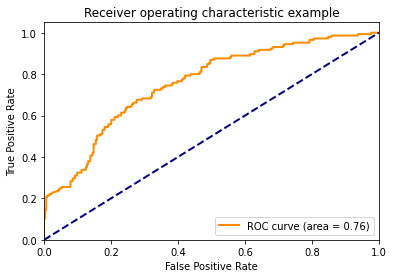

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
# from scipy import interp


# ylabel=label_binarize(y_testp,classes=[0,1])
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(2):
fpr, tpr, _ = roc_curve(y_testp, y_predit[:, 1])
roc_auc = auc(fpr, tpr)
# fpr[0].shape==tpr[0].shape==(21, ), fpr[1].shape==tpr[1].shape==(35, ), fpr[2].shape==tpr[2].shape==(33, ) 
# roc_auc {0: 0.9118165784832452, 1: 0.6029629629629629, 2: 0.7859477124183007}

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
